## Business Understanding

Healthcare systems operate under constant financial pressure, and within public healthcare programs, prescription drug spending is one of the fastest-growing cost drivers. Medicaid, which provides coverage for millions of individuals across U.S. states, allocates billions annually toward outpatient prescription drugs. To monitor this spending, the program publishes State Drug Utilization Data (SDUD), a comprehensive dataset capturing prescription volumes, reimbursement amounts, and drug utilization patterns across states and time periods.

Despite the richness of this dataset, its use in practice is largely retrospective. Analysts and policymakers primarily rely on descriptive reporting to understand what has already happened rather than what is likely to happen next. Budgets are reviewed after costs rise. Spending trends are analyzed after they occur. Policy responses are often reactive instead of proactive.

For state Medicaid agencies, insurers, and policy planners, the critical need is not just visibility into past spending. It is foresight. Decision-makers require tools that can anticipate expenditure patterns before they materialize so they can allocate resources, negotiate pricing strategies, and implement cost-control policies in advance. This gap between available data and predictive decision support represents a missed opportunity to leverage analytics for smarter healthcare financial management.

## Problem Statement

Modern healthcare systems generate vast amounts of data, yet many decisions are still made using backward-looking analysis. Medicaid’s drug utilization dataset is a prime example: it records millions of transactions across states, drugs, and quarters, but is typically used only to summarize historical spending.
Here begs the question, **Can we predict Medicaid drug spending from utilization patterns before costs escalate?**

Existing analyses largely describe spending patterns or evaluate specific drug categories, but there is limited evidence of scalable predictive modeling approaches that forecast reimbursement across many drugs and regions simultaneously. This means policymakers lack reliable tools to anticipate financial pressure points within drug programs.

Without predictive insight, resource planning becomes reactive, high-cost drugs are identified only after budgets are strained, and cost-containment strategies are delayed. The absence of generalizable, data-driven forecasting models for Medicaid reimbursement therefore represents a clear analytical and operational gap. This project addresses that gap by transforming descriptive utilization data into a predictive framework capable of estimating reimbursement levels based on drug usage patterns, geographic variation, and temporal indicators. By doing so, it shifts the analytical paradigm from hindsight to foresight.

# Problem Statement

Healthcare programs such as Medicaid allocate substantial financial resources each year toward prescription drug coverage. Managing this spending is critical for effective budgeting, policy planning, and ensuring that healthcare resources are used efficiently. However, the scale and complexity of drug utilization data make it challenging for analysts and policymakers to quickly detect spending patterns, identify high-cost drugs, and understand reimbursement trends across regions and time periods.

Current reporting systems primarily emphasize retrospective analysis, focusing on summarizing past expenditures rather than anticipating future costs. While descriptive reports are valuable for monitoring historical performance, they provide limited support for proactive decision-making. Without predictive insight, stakeholders may struggle to identify emerging cost drivers early, delaying interventions that could improve financial planning and cost control.

This project addresses that gap by analyzing Medicaid drug utilization data to uncover key spending patterns and by developing a machine learning model capable of predicting drug reimbursement amounts based on utilization metrics, product characteristics, geographic variation, and temporal indicators. In addition, a simple web-based application will be implemented to demonstrate how predictive outputs can support interactive exploration and scenario-based decision making for stakeholders.

Although the available dataset is limited to two quarters within a single year, the study serves as a proof-of-concept demonstrating how predictive analytics can be applied to administrative healthcare data. The framework is designed to be extensible and can be scaled to incorporate additional historical data, enabling more robust forecasting and broader policy applications in future implementations.


## Project Objectives
### Main Objective

Can we develop a predictive modeling framework that estimates Medicaid drug reimbursement amounts using utilization, product, geographic, and temporal features, thereby enabling proactive financial planning and data-driven decision-making?

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/Medicaid_data.csv")
df.head()

,Utilization Type,State,NDC,Labeler Code,Product Code,Package Size,Year,Quarter,Suppression Used,Product Name,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed
0,FFSU,AK,2143380,2,1433,80,2025,2,False,TRULICITY,216.0,107.0,102976.40,98630.87,4345.53
1,FFSU,AK,2143480,2,1434,80,2025,2,False,TRULICITY,218.0,109.0,104481.92,101806.64,2675.28
2,FFSU,AK,2143611,2,1436,11,2025,2,False,EMGALITY P,21.0,20.0,15227.25,15227.25,0.00
3,FFSU,AK,2144511,2,1445,11,2025,2,False,TALTZ AUTO,33.0,30.0,231532.28,231532.28,0.00
4,FFSU,AK,2145780,2,1457,80,2025,2,False,MOUNJARO,208.0,104.0,108908.80,105953.32,2955.48


In [3]:
df.columns

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed'],
      dtype='object')

## Checking for Outliers Using Interquatile Range

In [4]:
# Select your target column
column = "Total Amount Reimbursed"

# Calculate Q1 and Q3
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Number of Outliers:", outliers.shape[0])
print("Percentage of Outliers:", (outliers.shape[0] / df.shape[0]) * 100)

Lower Bound: -9221.155
Upper Bound: 16410.325
Number of Outliers: 210679
Percentage of Outliers: 16.040770612389093


### Standardizing Product Names

In [5]:
import re


df["Product Name_raw"] = df["Product Name"]

def clean_product_name(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()                 
    x = re.sub(r"\s+", " ", x)        
    x = x.casefold()                   
    return x

df["Product Name_std"] = df["Product Name_raw"].apply(clean_product_name)

In [6]:
# Remove the national/suppressed "XX" row
df = df[df['State'] != 'XX'].copy()
print("Dataset shape after removing XX:", df.shape)
print("Remaining states:", sorted(df['State'].unique()))

Dataset shape after removing XX: (1194315, 17)
Remaining states: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [7]:
df.columns

Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed', 'Product Name_raw',
       'Product Name_std'],
      dtype='object')

## Grouping Top 300 Drugs

In [8]:
top_drugs = (
    df.groupby("Product Name_std")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(300)
      .index
)

df_filtered = df[df["Product Name_std"].isin(top_drugs)].copy()

print("Original rows:", len(df))
print("Filtered rows:", len(df_filtered))
print("Unique drugs after filter:", df_filtered["Product Name_std"].nunique())

Original rows: 1194315
Filtered rows: 261177
Unique drugs after filter: 300


In [9]:
df_filtered["log_spending"] = np.log1p(df_filtered["Total Amount Reimbursed"])

## Modelling

In [10]:
y = df_filtered["log_spending"]

X = df_filtered[["State", "Product Name_std", "Quarter", "Number of Prescriptions", "Units Reimbursed"]]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape


((195882, 5), (65295, 5))

In [12]:
categorical_features = ["State", "Product Name_std", "Quarter"]
numeric_features = ["Units Reimbursed", "Number of Prescriptions"]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

Categorical: ['State', 'Product Name_std', 'Quarter']
Numeric: ['Units Reimbursed', 'Number of Prescriptions']


In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [14]:
pipeline_lr = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression MAE:", mae_lr)
print("Linear Regression R2:", r2_lr)

Linear Regression MAE: 1.2980187550346236
Linear Regression R2: 0.5883716877654711


In [16]:
df_filtered["Product Name_std"].nunique()

300

In [17]:
from sklearn.ensemble import RandomForestRegressor
pipeline_rf = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=30,
    max_depth=15,
    n_jobs=-1,
    random_state=42
    ))
])

pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MAE:", mae_rf)
print("Random Forest R2:", r2_rf)

Random Forest MAE: 1.0817876548913186
Random Forest R2: 0.611206128868997


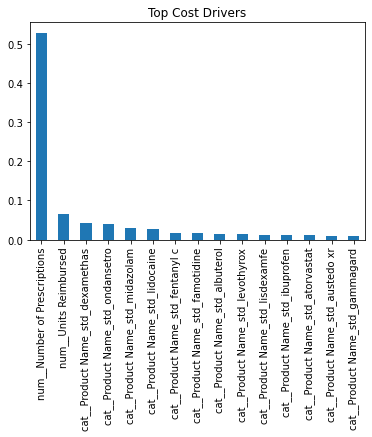

num__Number of Prescriptions        0.527983
num__Units Reimbursed               0.066600
cat__Product Name_std_dexamethas    0.043410
cat__Product Name_std_ondansetro    0.041025
cat__Product Name_std_midazolam     0.028990
cat__Product Name_std_lidocaine     0.026595
cat__Product Name_std_fentanyl c    0.017173
cat__Product Name_std_famotidine    0.016052
cat__Product Name_std_albuterol     0.014536
cat__Product Name_std_levothyrox    0.013556
cat__Product Name_std_lisdexamfe    0.012825
cat__Product Name_std_ibuprofen     0.011740
cat__Product Name_std_atorvastat    0.011700
cat__Product Name_std_austedo xr    0.009775
cat__Product Name_std_gammagard     0.008577
dtype: float64

In [20]:
#Feature Importance

import pandas as pd
import matplotlib.pyplot as plt

# extract trained model from pipeline
rf_model = pipeline_rf.named_steps["model"]

# feature names after preprocessing
feature_names_out = pipeline_rf.named_steps["preprocessing"].get_feature_names_out()

# importance
importance = pd.Series(rf_model.feature_importances_, index=feature_names_out)
importance = importance.sort_values(ascending=False)

# plot top features
plt.figure()
importance.head(15).plot(kind="bar")
plt.title("Top Cost Drivers")
plt.show()

importance.head(15)


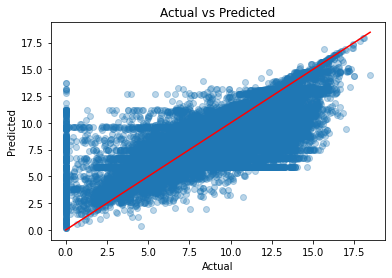

In [22]:
plt.figure()
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.show()


In [19]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline_gb = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

pipeline_gb.fit(X_train, y_train)

y_pred_gb = pipeline_gb.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score

print("Gradient Boosting MAE:", mean_absolute_error(y_test, y_pred_gb))
print("Gradient Boosting R2:", r2_score(y_test, y_pred_gb))


Gradient Boosting MAE: 1.2249983322461506
Gradient Boosting R2: 0.5495391282869422
